In [1]:
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph

n = 250

tau1 = 2.5

tau2 = 1.5

mu = 0.1

G0 = LFR_benchmark_graph(

    n, tau1, tau2, mu, average_degree=6, min_community=30, seed=7

)

G1 = G0.copy()
#G1 = LFR_benchmark_graph(

#    n, tau1, tau2, mu, average_degree=6, min_community=40, seed=7

#)

G = nx.union(G0, G1, rename=("0-", "1-"))

### 去掉 G 中的重边和自环 
G = nx.Graph(G) # Remove multi-edges

selfloop_edges = list(nx.selfloop_edges(G)) # a list of self loops

G.remove_edges_from(selfloop_edges) # Remove self-loops

#G.nodes()

Subgraph 0
Number of nodes: 250
Number of edges: 670

Subgraph 1
Number of nodes: 250
Number of edges: 670



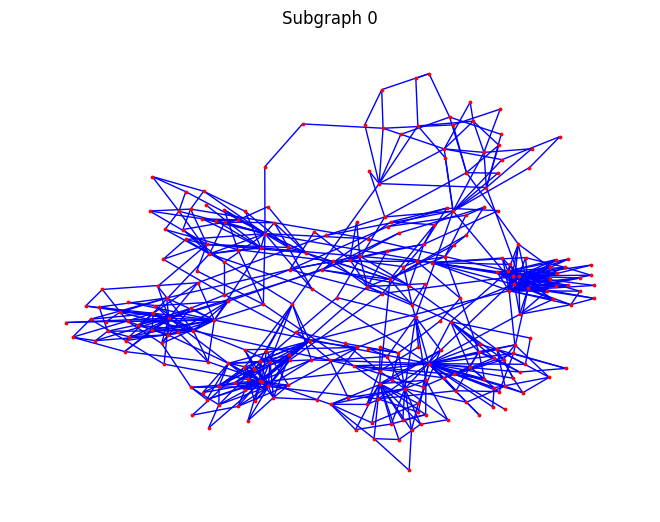

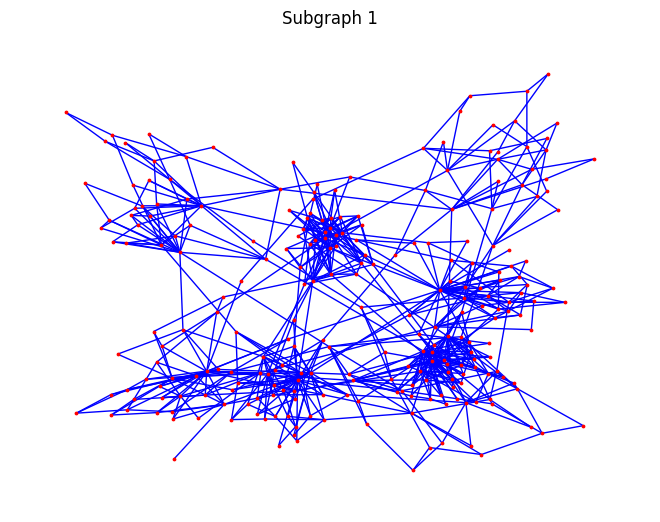

In [2]:
import matplotlib.pyplot as plt

# Get the connected components
components = nx.connected_components(G)

# Create a list to store the subgraphs
subgraphs = []

# Create a subgraph for each component
for component in components:
    subgraph = G.subgraph(component)
    subgraphs.append(subgraph)

# Print the number of nodes and edges in each subgraph
for i, subgraph in enumerate(subgraphs):
    print("Subgraph", i)
    print("Number of nodes:", subgraph.number_of_nodes())
    print("Number of edges:", subgraph.number_of_edges())
    print()

# Draw each subgraph separately
for i, subgraph in enumerate(subgraphs):
    plt.figure()
    nx.draw(subgraph, pos=nx.spring_layout(subgraph),node_color='r', node_size=3, edge_color='b')
    plt.title("Subgraph " + str(i))

plt.show()


In [3]:
int0 = {frozenset(G0.nodes[v]["community"]) for v in G0}
intrinsic_membership = {}
for node in range(G0.number_of_nodes()):
    for index, inner_set in enumerate(int0):
        if node in inner_set:
            intrinsic_membership[f"0-{node}"] = index
            break
intrinsic_membership0 = {}
for node in range(G0.number_of_nodes()):
    for index, inner_set in enumerate(int0):
        if node in inner_set:
            intrinsic_membership0[node] = index
            break
cumu = max(intrinsic_membership0.values())+1

int1 = {frozenset(G1.nodes[v]["community"]) for v in G1}
for node in range(G1.number_of_nodes()):
    for index, inner_set in enumerate(int1):
        if node in inner_set:
            intrinsic_membership[f"1-{node}"] = index+ cumu
            break

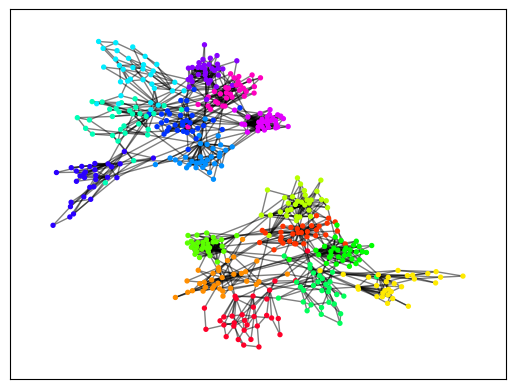

In [4]:
import matplotlib
from community import community_louvain

louvain_membership = community_louvain.best_partition(G)

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G,
                      pos,
                      louvain_membership.keys(),
                      node_size=8,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(louvain_membership.values())
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)

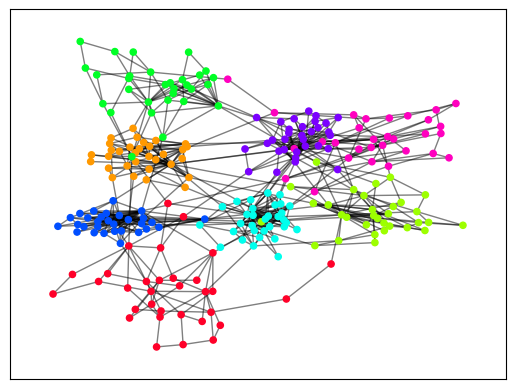

In [5]:
s0 = subgraphs[0]
louvain_membership0 = community_louvain.best_partition(s0)
pos = nx.spring_layout(s0);

nx.draw_networkx_nodes(s0,
                      pos,
                      louvain_membership0.keys(),
                      node_size=20,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(louvain_membership0.values())
                      )
nx.draw_networkx_edges(s0, pos, alpha=0.5)

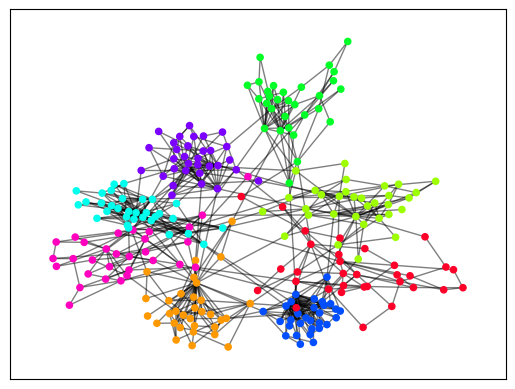

In [6]:
s1 = subgraphs[1]
louvain_membership1 = community_louvain.best_partition(s1)
pos = nx.spring_layout(s1);

nx.draw_networkx_nodes(s1,
                      pos,
                      louvain_membership1.keys(),
                      node_size=20,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(louvain_membership1.values())
                      )
nx.draw_networkx_edges(s1, pos, alpha=0.5)

In [7]:
from auxpack.evaluate_clustering import NMI

print(NMI(intrinsic_membership, louvain_membership))

1.0


In [8]:
for key in louvain_membership1:
    louvain_membership1[key] = louvain_membership1[key]+cumu
par = {**louvain_membership0, **louvain_membership1}
print(NMI(intrinsic_membership, par))

1.0


In [9]:
### 聚类算法 输出NMI及 ECSim

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors

from pyspark.ml.clustering import KMeans

from sklearn.metrics import normalized_mutual_info_score
import clusim.sim as sim
from clusim.clustering import Clustering

def evaluate_embedding(intr_list, evala, K): 
# 输入参数 的两个 intr 为内蕴聚类
# eval 的类型为向量 表示嵌入向量
    return_val = [] # 首先准备好返回值 
    ## 首先做 K Mean
    # Create a Spark DataFrame from the points
    # from pyspark.sql import SparkSession
    # from pyspark.ml.linalg import Vectors

    evala_spark = SparkSession.builder.getOrCreate()

    evala_vec = [Vectors.dense(row) for row in evala]
    
    evala_prep = SparkSession.builder.getOrCreate().\
                            createDataFrame([(vector,) for vector in evala_vec], ["embd"])

    # from pyspark.ml.clustering import KMeans

    # Create and fit the KMeans model
    euclid_kmeans = KMeans(k=K, featuresCol="embd")
    cosine_kmeans = KMeans(k=K, featuresCol="embd", distanceMeasure="cosine")
    evala_euclid_model = euclid_kmeans.fit(evala_prep)
    evala_cosine_model = cosine_kmeans.fit(evala_prep)


    # Add the cluster assignment to the DataFrame
    evala_euclid = evala_euclid_model.transform(evala_prep)
    evala_cosine = evala_cosine_model.transform(evala_prep)


    # Extract the cluster assignment and convert it to a list
    evala_euclid_membership = evala_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
    evala_cosine_membership = evala_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()

    ## 然后开始与内蕴聚类进行比较
    return_val.append(normalized_mutual_info_score(evala_euclid_membership, intr_list))
    return_val.append(normalized_mutual_info_score(evala_cosine_membership, intr_list))
    
    return return_val

In [10]:
print("The number of intrinsic communities in G0 is ", cumu)
print("The number of intrinsic communities in G1 is ", max(intrinsic_membership.values())+1-cumu)
print("The number of intrinsic communities in G is ", max(intrinsic_membership.values())+1)

The number of intrinsic communities in G0 is  8
The number of intrinsic communities in G1 is  8
The number of intrinsic communities in G is  16


In [11]:
### 2 Laplacian 方法 第一部分
from gem.embedding.lap import LaplacianEigenmaps
lap_model = LaplacianEigenmaps(d=7)

lap_embd = lap_model.learn_embedding(graph=s0, is_weighted=True, no_python=True)
evaluate_embedding(list(intrinsic_membership.values())[:250], lap_embd, cumu)

<class 'networkx.utils.decorators.argmap'> compilation 32:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/27 00:47:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/27 00:47:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


[0.9315696768840683, 0.9240824017008453]

In [12]:
### 2 Laplacian 方法 第二部分
from gem.embedding.lap import LaplacianEigenmaps
lap_model = LaplacianEigenmaps(d=7)

lap_embd = lap_model.learn_embedding(graph=s1, is_weighted=True, no_python=True)
evaluate_embedding(list(intrinsic_membership.values())[250:], lap_embd, max(intrinsic_membership.values())+1-cumu)

<class 'networkx.utils.decorators.argmap'> compilation 32:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


[0.9315696768840683, 0.9240824017008453]

In [13]:
### 2 Laplacian 方法 汇总  #This function should be checked further...
from gem.embedding.lap import LaplacianEigenmaps
lap_model = LaplacianEigenmaps(d=12)

lap_embd = lap_model.learn_embedding(graph=G, is_weighted=True, no_python=True)
evaluate_embedding(list(intrinsic_membership.values()), lap_embd, max(intrinsic_membership.values())+1)

<class 'networkx.utils.decorators.argmap'> compilation 32:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


[0.9341896600016555, 0.9323495614140129]

In [14]:
###############################
### Correct Graph LLE
###############################
import numpy as np
import networkx as nx
from sklearn.preprocessing import normalize
import scipy.linalg as lg

#def custom_sort(value):
#    parts = value.split('-')
#    return int(parts[0]), int(parts[1])


def lleone(graph, dim):
    A = nx.to_numpy_array(graph,graph.nodes(),
                          #sorted(graph.nodes(), key=custom_sort),
                          weight='weight')    
    normalize(A, norm='l1', axis=1, copy=False)
    I_n = np.eye(graph.number_of_nodes())
    I_min_A = np.dot((I_n - A).T, (I_n - A))
    w, v = lg.eig(I_min_A)
    idx = np.argsort(w.real)
    v = v[:, idx]
    embedding = v[:, 1:(dim+1)]
    return embedding

def lletwo(graph, dim):
    A = nx.to_numpy_array(graph, 
                          #nodelist=sorted(graph.nodes()),
                          #sorted(graph.nodes(), key=custom_sort),
                          graph.nodes(),
                          weight='weight')
    normalize(A, norm='l1', axis=1, copy=False)
    I_n = np.eye(graph.number_of_nodes())
    I_min_A = np.dot((I_n - A).T, (I_n - A))
    w, v = lg.eig(I_min_A)
    idx = np.argsort(w.real)
    v = v[:, idx]
    embedding = v[:, 2:(dim+2)]
    return embedding

In [15]:
for D in range(5,15):
    lleone_embd = lleone(s0,D)
    print(evaluate_embedding(list(intrinsic_membership0.values()), lleone_embd, cumu)
         )

[0.9743762746344038, 0.957374608112208]
[0.9743762746344038, 0.9516042084950838]
[0.9743762746344038, 0.9743762746344038]
[0.9109177637303543, 0.8965124653565977]
[0.857920378722704, 0.9050744167144499]
[0.84239922731287, 0.82927558615653]
[0.8753824400133386, 0.9743762746344038]
[0.7395016262634503, 0.9743762746344038]
[0.6906510453426976, 0.7966077243835806]
[0.6302858941256889, 0.8814587118313365]


In [16]:
for D in range(5,15):
    lletwo_embd = lletwo(G,D)
    print(evaluate_embedding(list(intrinsic_membership.values()), 
                             lletwo_embd, max(intrinsic_membership.values())+1)
         )

[0.9119245889386247, 0.82897187486723]
[0.8838275783341896, 0.8831153731576817]
[0.9353671077883627, 0.9064928508585292]
[0.9409222395131203, 0.9353731668921555]
[0.9268150663335697, 0.9435633643291208]
[0.9744339616956864, 0.9354073328104209]
[0.9776445501769867, 0.933320353519598]
[0.9351304555920064, 0.9453586282186635]
[0.9299145417163, 0.956696173060079]
[0.9685932469315744, 0.9807839135903389]


In [17]:
# This is a mistake b/c G has two components
for D in range(5,15):
    lleone_embd = lleone(G,D)
    print(evaluate_embedding(list(intrinsic_membership.values()), lleone_embd, max(intrinsic_membership.values())+1)
         )

[0.8926487252015814, 0.8280189582769417]
[0.9165321361678854, 0.8281518205502502]
[0.9257984235851815, 0.9035114704216894]
[0.9212580790038625, 0.9191972143938961]
[0.943837831629335, 0.9469344896590232]
[0.9472874505227579, 0.9455732986618781]
[0.9553503654028885, 0.9370466051739776]
[0.9540154906724859, 0.9270536948821075]
[0.9626560215974965, 0.953198177668268]
[0.9290643554189002, 0.9575238995148271]


In [18]:
### When we transform the instrinsic community dict into a list, the order is well preserved, so it's pretty OK.
import itertools
print(dict(itertools.islice(intrinsic_membership.items(), 20)))

print(list(intrinsic_membership.values())[:20])

{'0-0': 5, '0-1': 3, '0-2': 0, '0-3': 2, '0-4': 6, '0-5': 6, '0-6': 0, '0-7': 0, '0-8': 4, '0-9': 2, '0-10': 7, '0-11': 3, '0-12': 4, '0-13': 2, '0-14': 4, '0-15': 0, '0-16': 0, '0-17': 2, '0-18': 5, '0-19': 5}
[5, 3, 0, 2, 6, 6, 0, 0, 4, 2, 7, 3, 4, 2, 4, 0, 0, 2, 5, 5]
